In [1]:
%%capture
# Compile and import local pyrossgeo module
import os, sys
owd = os.getcwd()
os.chdir('../../')
sys.path.insert(0,'../../')
!python setup.py build_ext --inplace
os.chdir(owd)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyrossgeo

import pandas as pd
import json

running build_ext
copying build/lib.linux-x86_64-3.7/pyrossgeo/Simulation.cpython-37m-x86_64-linux-gnu.so -> pyrossgeo
copying build/lib.linux-x86_64-3.7/pyrossgeo/__defs__.cpython-37m-x86_64-linux-gnu.so -> pyrossgeo
copying build/lib.linux-x86_64-3.7/pyrossgeo/_helpers.cpython-37m-x86_64-linux-gnu.so -> pyrossgeo
copying build/lib.linux-x86_64-3.7/pyrossgeo/_initialization.cpython-37m-x86_64-linux-gnu.so -> pyrossgeo
copying build/lib.linux-x86_64-3.7/pyrossgeo/_simulation.cpython-37m-x86_64-linux-gnu.so -> pyrossgeo


Simulation parameters

In [2]:
model_path = 'model.json' 
commuter_networks_path = 'commuter_networks.csv'
node_parameters_path = 'node_parameters.csv'
cnode_parameters_path = 'cnode_parameters.csv' 
contact_matrices_path = 'contact_matrices.json' 
node_cmatrices_path = 'node_cmatrices.csv' 
cnode_cmatrices_path = 'cnode_cmatrices.csv' 
node_positions_path = 'node_positions.csv' 
node_populations_path = 'node_populations.csv' 

In [3]:
event_times = [ 24*60*200, 24*60*250 ]

def event_function(sim, step_i, t, dt, X_state, dX_state):    
    if not sim.is_commuting_stopped():
        print("Day %s: Imposing lockdown." % (t / (24*60)))
        cmat = sim.get_contact_matrix('C_standard')
        sim.storage['cmat'] = np.array(cmat)
        cmat[:] = 0
        sim.stop_commuting(True)
    else:
        print("Day %s: Releasing lockdown." % (t / (24*60)))
        cmat = sim.get_contact_matrix('C_standard')
        cmat[:] = sim.storage['cmat']
        sim.stop_commuting(False)

Simulation settings

In [4]:
t_start = 0
t_end = 24*60*1000
dt = 1

Run simulation

In [5]:
sim = pyrossgeo.Simulation()

X_state = sim.initialize(model_path, commuter_networks_path,
                            node_parameters_path, cnode_parameters_path,
                            contact_matrices_path, node_cmatrices_path, cnode_cmatrices_path,
                            node_populations_path)

start_time = time.time()
dX_state = np.zeros(X_state.size)
sim_data = sim.simulate(X_state, t_start, t_end, dt, steps_per_save=10,
                       event_times=event_times, event_function=event_function)
end_time = time.time()
sim_time = (end_time - start_time)/(60*60)
print("Simulation complete. Run-time (h): %s" % sim_time)

ts, node_data, cnode_data, location_data, community_data, network_data = pyrossgeo.utils.get_simulation_data(sim_data)

ts_days = ts / (24*60)
ts_hours = ts / 60

Day 200.0: Imposing lockdown.
Day 250.0: Releasing lockdown.
Simulation complete. Run-time (h): 0.0005874830484390259


## Plot data

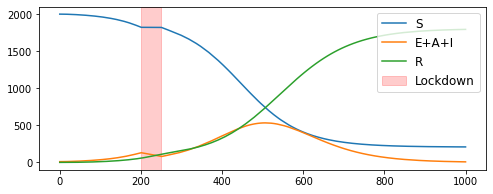

In [6]:
plt.figure( figsize=(8,3) )

S = np.sum(network_data[:,:,0], axis=1)
E = np.sum(network_data[:,:,1], axis=1)
A = np.sum(network_data[:,:,2], axis=1)
I = np.sum(network_data[:,:,3], axis=1)
R = np.sum(network_data[:,:,4], axis=1)

plt.plot(ts_days, S, label="S")
plt.plot(ts_days, E+A+I, label="E+A+I")
plt.plot(ts_days, R, label="R")

plt.axvspan(200, 250, alpha=0.2, color='red', label='Lockdown')

plt.legend(loc='upper right', fontsize=12)

In [7]:
plt.figure( figsize=(8,3) )

loc = 0

S = np.sum(location_data[:,:,0,loc], axis=1)
E = np.sum(location_data[:,:,1,loc], axis=1)
A = np.sum(location_data[:,:,2,loc], axis=1)
I = np.sum(location_data[:,:,3,loc], axis=1)
R = np.sum(location_data[:,:,4,loc], axis=1)
N = S + E + A + I + R

s = (ts_days > 190) * (ts_days < 210)

plt.plot(ts_days[s], S[s], label="S")
plt.plot(ts_days[s], (E+A+I)[s], label="I")
plt.plot(ts_days[s], R[s], label="R")
plt.plot(ts_days[s], N[s], label="N")

plt.legend(loc='upper right', fontsize=12)

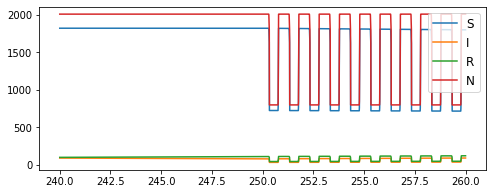

In [8]:
plt.figure( figsize=(8,3) )

loc = 0

S = np.sum(location_data[:,:,0,loc], axis=1)
E = np.sum(location_data[:,:,1,loc], axis=1)
A = np.sum(location_data[:,:,2,loc], axis=1)
I = np.sum(location_data[:,:,3,loc], axis=1)
R = np.sum(location_data[:,:,4,loc], axis=1)
N = S + E + A + I + R

s = (ts_days > 240) * (ts_days < 260)

plt.plot(ts_days[s], S[s], label="S")
plt.plot(ts_days[s], (E+A+I)[s], label="I")
plt.plot(ts_days[s], R[s], label="R")
plt.plot(ts_days[s], N[s], label="N")

plt.legend(loc='upper right', fontsize=12)